In [1]:
# Importing necessary libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np  # For numerical computations and array operations
import torch  # PyTorch library for deep learning
import torch.nn as nn  # PyTorch module for building neural networks
import torch.optim as optim  # PyTorch module for optimization algorithms
from torch.utils.data import Dataset, DataLoader, random_split  # Tools for creating datasets and data loaders
import ast  # For processing Abstract Syntax Trees (e.g., parsing strings into Python objects)
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # For data normalization and encoding categorical features
from sklearn.decomposition import PCA  # For dimensionality reduction using Principal Component Analysis
import cv2  # OpenCV library for image processing
from tqdm import tqdm  # For creating progress bars
import matplotlib.pyplot as plt  # For data visualization
import random  # Python module for generating random numbers

# Setting random seeds for reproducibility
random.seed(42)  # Set the random seed for Python's random module
np.random.seed(42)  # Set the random seed for NumPy
torch.manual_seed(42)  # Set the random seed for PyTorch CPU operations
torch.cuda.manual_seed(42)  # Set the random seed for PyTorch GPU operations (single device)
torch.cuda.manual_seed_all(42)  # Set the random seed for PyTorch GPU operations (all devices)


In [2]:
class DataPreprocessor:
    def __init__(self):
        # Initialize preprocessing objects
        self.cgm_scaler = None  # For scaling CGM data
        self.demo_onehot_encoder = None  # For encoding categorical demographic data
        self.demo_num_scaler = None  # For scaling numerical demographic data
        self.demo_viome_scaler = None  # For scaling Viome data
        self.demo_viome_pca = None  # For PCA on Viome data
        self.image_scaler = None  # For scaling image data
        self.label_scaler = None  # For scaling label data

    def fit_preprocess_demo_data(self, demo_file, cgm_file):
        # Load demographic and CGM data
        demo_data = pd.read_csv(demo_file)
        cgm_data = pd.read_csv(cgm_file)

        # Define categorical and numerical columns
        cat_columns = ['Gender', 'Race', 'Diabetes Status']
        num_columns = ['Age', 'Weight', 'Height', 'A1C', 'Baseline Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol', 'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI']

        # One-hot encode categorical data
        self.demo_onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded_cats = self.demo_onehot_encoder.fit_transform(demo_data[cat_columns])

        # Scale numerical data
        self.demo_num_scaler = StandardScaler()
        normalized_nums = self.demo_num_scaler.fit_transform(demo_data[num_columns])

        # Process Viome data
        viome_data = demo_data['Viome'].apply(lambda x: np.array(x.split(','), dtype=float))
        viome_matrix = np.vstack(viome_data.values)
        self.demo_viome_scaler = StandardScaler()
        viome_matrix_scaled = self.demo_viome_scaler.fit_transform(viome_matrix)

        # Apply PCA to Viome data
        self.demo_viome_pca = PCA(n_components=2)
        viome_pca = self.demo_viome_pca.fit_transform(viome_matrix_scaled)

        # Combine all processed features
        processed_demo = np.hstack((encoded_cats, normalized_nums, viome_pca))

        # Create a map of subject IDs to processed demographic data
        subject_demo_map = {subject: data for subject, data in zip(demo_data['Subject ID'], processed_demo)}

        # Replicate demographic data based on CGM data
        replicated_demo = []
        for _, row in cgm_data.iterrows():
            subject_id = row['Subject ID']
            replicated_demo.append(subject_demo_map[subject_id])

        # Create column names for the processed data
        columns = (self.demo_onehot_encoder.get_feature_names_out(cat_columns).tolist() + num_columns + ['PC1', 'PC2'])

        # Create a DataFrame with the replicated data
        replicated_demo_df = pd.DataFrame(replicated_demo, columns=columns)
        replicated_demo_df.insert(0, 'Subject ID', cgm_data['Subject ID'])
        replicated_demo_df.insert(1, 'Day', cgm_data['Day'])

        # Convert to PyTorch tensor
        replicated_demo_tensor = torch.FloatTensor(replicated_demo).unsqueeze(-1)
        return replicated_demo_tensor

    def transform_preprocess_demo_data(self, demo_file, cgm_file):
        # Load demographic and CGM data
        demo_data = pd.read_csv(demo_file)
        cgm_data = pd.read_csv(cgm_file)

        # Define categorical and numerical columns
        cat_columns = ['Gender', 'Race', 'Diabetes Status']
        num_columns = ['Age', 'Weight', 'Height', 'A1C', 'Baseline Fasting Glucose', 'Insulin', 'Triglycerides', 'Cholesterol', 'HDL', 'Non-HDL', 'LDL', 'VLDL', 'CHO/HDL Ratio', 'HOMA-IR', 'BMI']

        # Transform categorical data using pre-fitted encoder
        encoded_cats = self.demo_onehot_encoder.transform(demo_data[cat_columns])

        # Transform numerical data using pre-fitted scaler
        normalized_nums = self.demo_num_scaler.transform(demo_data[num_columns])

        # Process Viome data
        viome_data = demo_data['Viome'].apply(lambda x: np.array(x.split(','), dtype=float))
        viome_matrix = np.vstack(viome_data.values)
        viome_matrix_scaled = self.demo_viome_scaler.transform(viome_matrix)

        # Apply pre-fitted PCA to Viome data
        viome_pca = self.demo_viome_pca.transform(viome_matrix_scaled)

        # Combine all processed features
        processed_demo = np.hstack((encoded_cats, normalized_nums, viome_pca))

        # Create a map of subject IDs to processed demographic data
        subject_demo_map = {subject: data for subject, data in zip(demo_data['Subject ID'], processed_demo)}

        # Replicate demographic data based on CGM data
        replicated_demo = []
        for _, row in cgm_data.iterrows():
            subject_id = row['Subject ID']
            replicated_demo.append(subject_demo_map[subject_id])

        # Create column names for the processed data
        columns = (self.demo_onehot_encoder.get_feature_names_out(cat_columns).tolist() + num_columns + ['PC1', 'PC2'])

        # Create a DataFrame with the replicated data
        replicated_demo_df = pd.DataFrame(replicated_demo, columns=columns)
        replicated_demo_df.insert(0, 'Subject ID', cgm_data['Subject ID'])
        replicated_demo_df.insert(1, 'Day', cgm_data['Day'])

        # Convert to PyTorch tensor
        replicated_demo_tensor = torch.FloatTensor(replicated_demo).unsqueeze(-1)
        return replicated_demo_tensor

    def fit_preprocess_labels(self, label_file):
        # Load and preprocess label data
        labels = pd.read_csv(label_file)
        lunch_calories = labels['Lunch Calories'].values.reshape(-1, 1)

        # Scale lunch calorie data
        self.label_scaler = StandardScaler()
        scaled_lunch_calories = self.label_scaler.fit_transform(lunch_calories)

        # Convert to PyTorch tensor
        lunch_calories_tensor = torch.FloatTensor(scaled_lunch_calories)
        return lunch_calories_tensor

    def fit_preprocess_cgm_data(self, cgm_file):
        # Load CGM data
        cgm_data = pd.read_csv(cgm_file)
        feature_list = []

        # Extract features from CGM time series data
        for index, row in cgm_data.iterrows():
            try:
                # Parse CGM data and create time series
                cgm_list = ast.literal_eval(row['CGM Data'])
                time_values = [x[0] for x in cgm_list if x[1] is not None]
                glucose_values = [float(x[1]) for x in cgm_list if x[1] is not None]
                time_series = pd.Series(glucose_values, index=pd.to_datetime(time_values))

                # Resample and interpolate time series
                time_series = time_series.resample('5min').mean().interpolate('linear').fillna(0)

                # Calculate various statistics
                mean_glucose = time_series.mean()
                std_glucose = time_series.std()
                min_glucose = time_series.min()
                max_glucose = time_series.max()
                range_glucose = max_glucose - min_glucose

                # Calculate pre-lunch statistics
                pre_lunch_mean = (
                    time_series[row['Breakfast Time']:row['Lunch Time']].mean()
                    if row['Lunch Time'] in time_series.index else 0
                )
                pre_lunch_std = (
                    time_series[row['Breakfast Time']:row['Lunch Time']].std()
                    if row['Lunch Time'] in time_series.index else 0
                )

                # Calculate trend
                trend = np.polyfit(range(len(time_series)), time_series, 1)[0]

                feature_list.append([
                    mean_glucose, std_glucose, min_glucose, max_glucose, range_glucose,
                    pre_lunch_mean, pre_lunch_std, trend
                ])
            except Exception as e:
                # Handle errors by appending zeros
                feature_list.append([0] * 8)

        # Create DataFrame with extracted features
        feature_df = pd.DataFrame(feature_list, columns=[
            'Mean Glucose', 'Std Glucose', 'Min Glucose', 'Max Glucose', 'Range Glucose',
            'Pre-Lunch Mean', 'Pre-Lunch Std', 'Trend'
        ])

        # Scale features
        self.cgm_scaler = StandardScaler()
        scaled_features = self.cgm_scaler.fit_transform(feature_df)

        # Convert to PyTorch tensor
        feature_tensor = torch.FloatTensor(scaled_features).unsqueeze(-1)
        return feature_tensor

    def transform_preprocess_cgm_data(self, cgm_file):
        # Load CGM data
        cgm_data = pd.read_csv(cgm_file)
        feature_list = []

        # Extract features from CGM time series data
        for index, row in cgm_data.iterrows():
            try:
                # Parse CGM data and create time series
                cgm_list = ast.literal_eval(row['CGM Data'])
                time_values = [x[0] for x in cgm_list if x[1] is not None]
                glucose_values = [float(x[1]) for x in cgm_list if x[1] is not None]
                time_series = pd.Series(glucose_values, index=pd.to_datetime(time_values))

                # Resample and interpolate time series
                time_series = time_series.resample('5min').mean().interpolate('linear').fillna(0)

                # Calculate various statistics
                mean_glucose = time_series.mean()
                std_glucose = time_series.std()
                min_glucose = time_series.min()
                max_glucose = time_series.max()
                range_glucose = max_glucose - min_glucose

                # Calculate pre-lunch statistics
                pre_lunch_mean = (
                    time_series[row['Breakfast Time']:row['Lunch Time']].mean()
                    if row['Lunch Time'] in time_series.index else 0
                )
                pre_lunch_std = (
                    time_series[row['Breakfast Time']:row['Lunch Time']].std()
                    if row['Lunch Time'] in time_series.index else 0
                )

                # Calculate trend
                trend = np.polyfit(range(len(time_series)), time_series, 1)[0]

                feature_list.append([
                    mean_glucose, std_glucose, min_glucose, max_glucose, range_glucose,
                    pre_lunch_mean, pre_lunch_std, trend
                ])
            except Exception as e:
                # Handle errors by appending zeros
                feature_list.append([0] * 8)

        # Create DataFrame with extracted features
        feature_df = pd.DataFrame(feature_list, columns=[
            'Mean Glucose', 'Std Glucose', 'Min Glucose', 'Max Glucose', 'Range Glucose',
            'Pre-Lunch Mean', 'Pre-Lunch Std', 'Trend'
        ])

        # Scale features using pre-fitted scaler
        scaled_features = self.cgm_scaler.transform(feature_df)

        # Convert to PyTorch tensor
        feature_tensor = torch.FloatTensor(scaled_features).unsqueeze(-1)
        return feature_tensor

    def fit_preprocess_images(self, img_file, target_size=(64, 64)):
        def process_single_image(img_data):
            try:
                # Convert image data to numpy array
                img_array = np.array(ast.literal_eval(img_data), dtype=np.float32)

                # Resize image if necessary
                if img_array.shape != (*target_size, 3):
                    if len(img_array.shape) == 3:
                        img_array = cv2.resize(img_array, target_size)
                    else:
                        img_array = np.zeros((*target_size, 3), dtype=np.float32)

                # Convert color space and apply Gaussian blur
                img_array = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_BGR2RGB)
                img_array = cv2.GaussianBlur(img_array, (3,3), 0)
                return img_array
            except (ValueError, SyntaxError, TypeError):
                # Return zero array if processing fails
                return np.zeros((*target_size, 3), dtype=np.float32)

        # Load image data
        image_data = pd.read_csv(img_file)

        # Process breakfast and lunch images
        breakfast_images = [process_single_image(img) for img in image_data['Image Before Breakfast']]
        lunch_images = [process_single_image(img) for img in image_data['Image Before Lunch']]

        # Stack images into 4D arrays
        breakfast_images = np.stack(breakfast_images)
        lunch_images = np.stack(lunch_images)

        # Fit scaler on combined image data
        self.image_scaler = StandardScaler()
        reshaped_breakfast = breakfast_images.reshape(-1, target_size[0] * target_size[1] * 3)
        reshaped_lunch = lunch_images.reshape(-1, target_size[0] * target_size[1] * 3)
        combined_images = np.vstack([reshaped_breakfast, reshaped_lunch])
        self.image_scaler.fit(combined_images)

        # Normalize pixel values
        breakfast_images = breakfast_images / 255.0
        lunch_images = lunch_images / 255.0

        # Convert to PyTorch tensors and rearrange dimensions
        breakfast_tensor = torch.FloatTensor(breakfast_images).permute(0, 3, 1, 2)
        lunch_tensor = torch.FloatTensor(lunch_images).permute(0, 3, 1, 2)

        return breakfast_tensor, lunch_tensor

    def transform_preprocess_images(self, img_file, target_size=(64, 64)):
        def process_single_image(img_data):
            try:
                # Convert string representation of image data to numpy array
                img_array = np.array(ast.literal_eval(img_data), dtype=np.float32)

                # Resize image if it doesn't match the target size
                if img_array.shape != (*target_size, 3):
                    if len(img_array.shape) == 3:
                        img_array = cv2.resize(img_array, target_size)
                    else:
                        # Create a blank image if the shape is invalid
                        img_array = np.zeros((*target_size, 3), dtype=np.float32)

                # Convert color space from BGR to RGB
                img_array = cv2.cvtColor(img_array.astype(np.uint8), cv2.COLOR_BGR2RGB)
                # Apply Gaussian blur for noise reduction
                img_array = cv2.GaussianBlur(img_array, (3,3), 0)

                return img_array

            except (ValueError, SyntaxError, TypeError):
                # Return a blank image if processing fails
                return np.zeros((*target_size, 3), dtype=np.float32)

        # Load image data from CSV file
        image_data = pd.read_csv(img_file)

        # Process breakfast and lunch images
        breakfast_images = [process_single_image(img) for img in image_data['Image Before Breakfast']]
        lunch_images = [process_single_image(img) for img in image_data['Image Before Lunch']]

        # Stack processed images into 3D arrays
        breakfast_images = np.stack(breakfast_images)
        lunch_images = np.stack(lunch_images)

        # Normalize pixel values to [0, 1] range
        breakfast_images = breakfast_images / 255.0
        lunch_images = lunch_images / 255.0

        # Convert to PyTorch tensors and rearrange dimensions (N, H, W, C) -> (N, C, H, W)
        breakfast_tensor = torch.FloatTensor(breakfast_images).permute(0, 3, 1, 2)
        lunch_tensor = torch.FloatTensor(lunch_images).permute(0, 3, 1, 2)

        return breakfast_tensor, lunch_tensor

In [3]:
class MultimodalDataset(Dataset):
    def __init__(self, cgm_file, demo_file, img_file, label_file=None, transform=None, preprocessor=None, is_train=True):
        # Initialize the dataset with various data files and preprocessing options
        if preprocessor:
            if is_train:
                # For training data, fit and preprocess the data
                self.cgm_data = preprocessor.fit_preprocess_cgm_data(cgm_file)
                self.demo_data = preprocessor.fit_preprocess_demo_data(demo_file, cgm_file)
                self.breakfast_images, self.lunch_images = preprocessor.fit_preprocess_images(img_file)

                if label_file:
                    # Preprocess labels if provided
                    self.labels = preprocessor.fit_preprocess_labels(label_file)
            else:
                # For non-training data, transform the data using pre-fitted preprocessors
                self.cgm_data = preprocessor.transform_preprocess_cgm_data(cgm_file)
                self.demo_data = preprocessor.transform_preprocess_demo_data(demo_file, cgm_file)
                self.breakfast_images, self.lunch_images = preprocessor.transform_preprocess_images(img_file)

        # Store the transform function for later use
        self.transform = transform
        # Flag to indicate whether labels are available
        self.has_labels = label_file is not None

    def __len__(self):
        # Return the number of samples in the dataset
        return len(self.cgm_data)

    def __getitem__(self, idx):
        # Retrieve a single sample from the dataset
        sample = {
            'cgm': self.cgm_data[idx],
            'demo': self.demo_data[idx],
            'breakfast_img': self.breakfast_images[idx],
            'lunch_img': self.lunch_images[idx]
        }

        # Apply transforms to the images if specified
        if self.transform:
            sample['breakfast_img'] = self.transform(sample['breakfast_img'])
            sample['lunch_img'] = self.transform(sample['lunch_img'])

        # Include label in the sample if available
        if self.has_labels:
            sample['label'] = self.labels[idx]

        return sample

In [4]:
class CGMEncoder(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=32):
        super(CGMEncoder, self).__init__()
        # LSTM layer for processing CGM time series data
        self.lstm = nn.LSTM(
            input_size=input_size,  # Number of features in input sequence
            hidden_size=hidden_size,  # Number of features in hidden state
            num_layers=num_layers,  # Number of recurrent layers
            batch_first=True,  # Input shape is (batch, seq, feature)
            dropout=0.2  # Dropout rate between LSTM layers
        )
        # Fully connected layer to produce final output
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Process input through LSTM
        lstm_out, _ = self.lstm(x)
        # Use only the last output of the sequence
        # Apply fully connected layer to get final output
        return self.fc(lstm_out[:, -1, :])

In [5]:
class ImageEncoder(nn.Module):
    def __init__(self, output_size=32):
        super(ImageEncoder, self).__init__()

        # Convolutional layers for feature extraction
        self.features = nn.Sequential(
            # First convolutional block
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # Input: 3 channels (RGB), Output: 32 feature maps
            nn.ReLU(),  # Activation function
            nn.BatchNorm2d(32),  # Batch normalization for faster convergence
            nn.MaxPool2d(2),  # Reduce spatial dimensions by half

            # Second convolutional block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # Input: 32 channels, Output: 64 feature maps
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            # Third convolutional block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Input: 64 channels, Output: 128 feature maps
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            # Fourth convolutional block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Input: 128 channels, Output: 256 feature maps
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )

        # Fully connected layers for classification
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),  # Regularization to prevent overfitting
            nn.Linear(256 * 4 * 4, 512),  # Flatten and reduce dimensions
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, output_size)  # Final layer to produce desired output size
        )

    def forward(self, x):
        x = self.features(x)  # Pass input through convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the output for fully connected layers
        x = self.classifier(x)  # Pass through fully connected layers
        return x

In [6]:
class DemoEncoder(nn.Module):
    def __init__(self, input_size=25, output_size=32):
        super(DemoEncoder, self).__init__()
        # Define the encoder architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 64),  # First fully connected layer
            nn.ReLU(),  # Activation function
            nn.BatchNorm1d(64),  # Batch normalization for faster convergence
            nn.Linear(64, output_size)  # Second fully connected layer
        )

    def forward(self, x):
        x = x.squeeze(-1)  # Remove the last dimension if it's 1
        return self.encoder(x)  # Pass input through the encoder

In [7]:
class ModalityEmbedding(nn.Module):
    def __init__(self, encoding_dim=32, embedding_dim=128):
        super(ModalityEmbedding, self).__init__()
        # Define the embedding layer
        self.embedding = nn.Sequential(
            nn.Linear(encoding_dim, embedding_dim),  # Linear transformation from encoding_dim to embedding_dim
            nn.LayerNorm(embedding_dim),  # Layer normalization for stability
            nn.ReLU()  # ReLU activation function
        )

    def forward(self, x):
        return self.embedding(x)  # Apply the embedding transformation to the input

In [8]:
class MultimodalAttentionFusion(nn.Module):
    def __init__(self, encoding_dim=32, embedding_dim=128, num_heads=4, dropout=0.1):
        super(MultimodalAttentionFusion, self).__init__()
        # Embedding layers for each modality
        self.cgm_embedding = ModalityEmbedding(encoding_dim, embedding_dim)
        self.demo_embedding = ModalityEmbedding(encoding_dim, embedding_dim)
        self.image_embedding = ModalityEmbedding(encoding_dim, embedding_dim)
        
        # Multi-head attention layer for fusion
        self.multihead_attn = nn.MultiheadAttention(embedding_dim, num_heads, dropout=dropout)
        
        # Layer normalization for attention output
        self.norm1 = nn.LayerNorm(embedding_dim)
        # Layer normalization for feed-forward output
        self.norm2 = nn.LayerNorm(embedding_dim)
        
        # Feed-forward network
        self.ffn = nn.Sequential(
            nn.Linear(embedding_dim, embedding_dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(embedding_dim * 4, embedding_dim)
        )
        
        # Final predictor layer
        self.predictor = nn.Linear(embedding_dim, 1)

    def forward(self, cgm_encoded, demo_encoded, breakfast_encoded, lunch_encoded):
        # Embed each modality
        cgm_embed = self.cgm_embedding(cgm_encoded)
        demo_embed = self.demo_embedding(demo_encoded)
        breakfast_embed = self.image_embedding(breakfast_encoded)
        lunch_embed = self.image_embedding(lunch_encoded)
        
        # Stack embeddings for attention
        embeddings = torch.stack([cgm_embed, demo_embed, breakfast_embed, lunch_embed])
        
        # Apply multi-head attention
        attn_output, _ = self.multihead_attn(embeddings, embeddings, embeddings)
        
        # Add & Norm (residual connection and layer normalization)
        attn_output = self.norm1(attn_output + embeddings)
        
        # Feed-forward network
        ffn_output = self.ffn(attn_output)
        
        # Add & Norm (residual connection and layer normalization)
        output = self.norm2(ffn_output + attn_output)
        
        # Average pooling across modalities
        fused_embedding = torch.mean(output, dim=0)
        
        # Final prediction
        lunch_calories = self.predictor(fused_embedding)
        
        return lunch_calories

In [9]:
# Set the device to GPU if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize encoder models and move them to the selected device
cgm_encoder = CGMEncoder().to(device)
image_encoder = ImageEncoder().to(device)
demo_encoder = DemoEncoder().to(device)
multimodal_model = MultimodalAttentionFusion().to(device)

# Create a data preprocessor instance
preprocessor = DataPreprocessor()

# Create training dataset
train_dataset = MultimodalDataset(
    cgm_file='cgm_train.csv',
    demo_file='demo_viome_train.csv',
    img_file='img_train.csv',
    label_file='label_train.csv',
    preprocessor=preprocessor,
    is_train=True
)

# Create testing dataset
test_dataset = MultimodalDataset(
    cgm_file='cgm_test.csv',
    demo_file='demo_viome_test.csv',
    img_file='img_test.csv',
    preprocessor=preprocessor,
    is_train=False
)

# Split training dataset into training and validation subsets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create data loaders for training, validation, and testing
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize Adam optimizer for all model parameters
optimizer = optim.Adam(
    list(cgm_encoder.parameters()) +
    list(image_encoder.parameters()) +
    list(demo_encoder.parameters()) +
    list(multimodal_model.parameters()),
    lr=0.0001
)

# Create learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)

# Define custom loss function (Root Mean Squared Relative Error)
def custom_loss(solution, submission):
    rmsre = torch.sqrt(torch.mean(((solution - submission) / solution) ** 2))
    return rmsre

C:\Users\dhruv\AppData\Local\Temp\ipykernel_7604\3498538583.py:135: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  time_series = pd.Series(glucose_values, index=pd.to_datetime(time_values))
C:\Users\dhruv\AppData\Local\Temp\ipykernel_7604\3498538583.py:135: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  time_series = pd.Series(glucose_values, index=pd.to_datetime(time_values))
C:\Users\dhruv\AppData\Local\Temp\ipykernel_7604\3498538583.py:135: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  time_series = pd.Series(glucose_values, index=pd.to_datetime(time_values))
C:\Users\dhruv\AppData\Local\Temp\ipykernel_7604\3498538583.py:135: FutureWarning:

Epoch [1/50], Train Loss: 1.0285, Val Loss: 1.1354
Epoch [2/50], Train Loss: 0.9558, Val Loss: 0.8958
Epoch [3/50], Train Loss: 0.8489, Val Loss: 0.7645
Epoch [4/50], Train Loss: 0.8405, Val Loss: 0.7485
Epoch [5/50], Train Loss: 0.8335, Val Loss: 0.7591
Epoch [6/50], Train Loss: 0.8024, Val Loss: 0.7160
Epoch [7/50], Train Loss: 0.8479, Val Loss: 0.7466
Epoch [8/50], Train Loss: 0.8383, Val Loss: 0.7165
Epoch [9/50], Train Loss: 0.7791, Val Loss: 0.6988
Epoch [10/50], Train Loss: 0.8304, Val Loss: 0.6919
Epoch [11/50], Train Loss: 0.7701, Val Loss: 0.7071
Epoch [12/50], Train Loss: 0.7767, Val Loss: 0.7237
Epoch [13/50], Train Loss: 0.7298, Val Loss: 0.7360
Epoch [14/50], Train Loss: 0.7162, Val Loss: 0.7876
Early stopping triggered at epoch 15


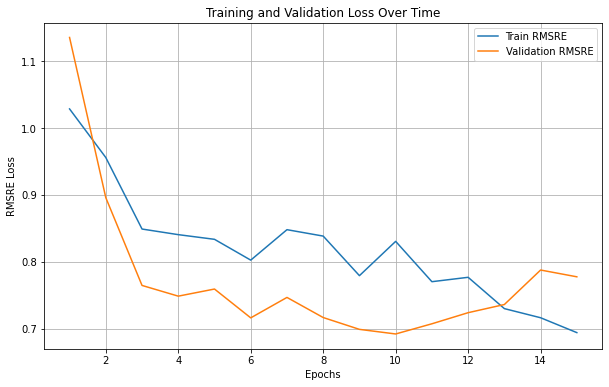

In [10]:
train_losses = []
val_losses = []

base_val_loss = float('inf')
base_model_state = None
patience = 5
patience_counter = 0
num_epochs = 50

# Learning rate scheduler to reduce LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

for epoch in range(num_epochs):
    # Set models to training mode
    cgm_encoder.train()
    image_encoder.train()
    demo_encoder.train()
    multimodal_model.train()

    epoch_train_losses = []
    for batch in train_loader:
        # Move batch data to device
        cgm_data = batch['cgm'].to(device)
        demo_data = batch['demo'].to(device)
        breakfast_img = batch['breakfast_img'].to(device)
        lunch_img = batch['lunch_img'].to(device)
        labels = batch['label'].to(device)

        # Forward pass through encoders
        cgm_encoded = cgm_encoder(cgm_data)
        demo_encoded = demo_encoder(demo_data)
        breakfast_encoded = image_encoder(breakfast_img)
        lunch_encoded = image_encoder(lunch_img)

        # Forward pass through multimodal model
        predictions = multimodal_model(
            cgm_encoded,
            demo_encoded,
            breakfast_encoded,
            lunch_encoded
        )

        # Calculate loss
        loss = custom_loss(labels, predictions)
        epoch_train_losses.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(
            list(cgm_encoder.parameters()) +
            list(image_encoder.parameters()) +
            list(demo_encoder.parameters()) +
            list(multimodal_model.parameters()),
            max_norm=1.0
        )

        optimizer.step()

    # Calculate average training loss for the epoch
    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    # Validation phase
    cgm_encoder.eval()
    image_encoder.eval()
    demo_encoder.eval()
    multimodal_model.eval()

    epoch_val_losses = []
    with torch.no_grad():
        for batch in val_loader:
            # Similar forward pass as in training, but without gradient calculation
            cgm_data = batch['cgm'].to(device)
            demo_data = batch['demo'].to(device)
            breakfast_img = batch['breakfast_img'].to(device)
            lunch_img = batch['lunch_img'].to(device)
            labels = batch['label'].to(device)

            cgm_encoded = cgm_encoder(cgm_data)
            demo_encoded = demo_encoder(demo_data)
            breakfast_encoded = image_encoder(breakfast_img)
            lunch_encoded = image_encoder(lunch_img)

            predictions = multimodal_model(
                cgm_encoded,
                demo_encoded,
                breakfast_encoded,
                lunch_encoded
            )

            val_loss = custom_loss(labels, predictions)
            epoch_val_losses.append(val_loss.item())

    # Calculate average validation loss for the epoch
    avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
    val_losses.append(avg_val_loss)

    # Update learning rate based on validation loss
    scheduler.step(avg_val_loss)

    # Early stopping and model checkpointing
    if avg_val_loss < base_val_loss:
        base_val_loss = avg_val_loss
        patience_counter = 0
        base_model_state = {
            'cgm_encoder': cgm_encoder.state_dict(),
            'image_encoder': image_encoder.state_dict(),
            'demo_encoder': demo_encoder.state_dict(),
            'multimodal_model': multimodal_model.state_dict()
        }
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train RMSRE')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation RMSRE')
plt.xlabel('Epochs')
plt.ylabel('RMSRE Loss')
plt.title('Training and Validation Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
def random_search(train_dataset, device, n_trials):
    import random
    best_val_loss = float('inf')  # Initialize best validation loss
    best_params = None  # Store best hyperparameters
    best_model_state = None  # Store best model state
    results = []  # List to store results of all trials

    # Define the hyperparameter search space
    param_space = {
        'lstm_hidden_size': [32, 64, 128],
        'lstm_layers': [1, 2],
        'encoding_dim': [32, 64],
        'embedding_dim': [64, 128],
        'num_heads': [4, 8],
        'dropout': [0.1, 0.2, 0.3],
        'batch_size': [16, 32],
        'learning_rate': [1e-3, 1e-4]
    }

    for trial in range(n_trials):
        # Randomly select hyperparameters for this trial
        params = {k: random.choice(v) for k, v in param_space.items()}

        print(f"\nTrial {trial+1}/{n_trials}")
        print(f"Parameters: {params}")

        # Split dataset into train and validation subsets
        train_size = int(0.8 * len(train_dataset))
        val_size = len(train_dataset) - train_size
        train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

        # Create data loaders
        train_loader = DataLoader(train_subset, batch_size=params['batch_size'], shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=params['batch_size'], shuffle=False)

        # Initialize model components with selected hyperparameters
        cgm_encoder = CGMEncoder(
            hidden_size=params['lstm_hidden_size'],
            num_layers=params['lstm_layers'],
            output_size=params['encoding_dim']
        ).to(device)

        image_encoder = ImageEncoder(output_size=params['encoding_dim']).to(device)
        demo_encoder = DemoEncoder(output_size=params['encoding_dim']).to(device)

        multimodal_model = MultimodalAttentionFusion(
            encoding_dim=params['encoding_dim'],
            embedding_dim=params['embedding_dim'],
            num_heads=params['num_heads'],
            dropout=params['dropout']
        ).to(device)

        # Initialize optimizer
        optimizer = optim.Adam(
            list(cgm_encoder.parameters()) +
            list(image_encoder.parameters()) +
            list(demo_encoder.parameters()) +
            list(multimodal_model.parameters()),
            lr=params['learning_rate']
        )

        # Initialize learning rate scheduler
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
        )

        best_trial_val_loss = float('inf')
        patience = 10
        patience_counter = 0

        for epoch in range(50):
            # Set models to training mode
            cgm_encoder.train()
            image_encoder.train()
            demo_encoder.train()
            multimodal_model.train()

            epoch_train_losses = []
            for batch in train_loader:
                # Move batch data to device
                cgm_data = batch['cgm'].to(device)
                demo_data = batch['demo'].to(device)
                breakfast_img = batch['breakfast_img'].to(device)
                lunch_img = batch['lunch_img'].to(device)
                labels = batch['label'].to(device)

                # Forward pass through encoders
                cgm_encoded = cgm_encoder(cgm_data)
                demo_encoded = demo_encoder(demo_data)
                breakfast_encoded = image_encoder(breakfast_img)
                lunch_encoded = image_encoder(lunch_img)

                # Forward pass through multimodal model
                predictions = multimodal_model(
                    cgm_encoded,
                    demo_encoded,
                    breakfast_encoded,
                    lunch_encoded
                )

                # Calculate loss
                loss = custom_loss(labels, predictions)
                epoch_train_losses.append(loss.item())

                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Calculate average training loss for the epoch
            avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)

            # Validation phase
            cgm_encoder.eval()
            image_encoder.eval()
            demo_encoder.eval()
            multimodal_model.eval()

            epoch_val_losses = []
            with torch.no_grad():
                for batch in val_loader:
                    # Similar forward pass as in training, but without gradient calculation
                    cgm_data = batch['cgm'].to(device)
                    demo_data = batch['demo'].to(device)
                    breakfast_img = batch['breakfast_img'].to(device)
                    lunch_img = batch['lunch_img'].to(device)
                    labels = batch['label'].to(device)

                    cgm_encoded = cgm_encoder(cgm_data)
                    demo_encoded = demo_encoder(demo_data)
                    breakfast_encoded = image_encoder(breakfast_img)
                    lunch_encoded = image_encoder(lunch_img)

                    predictions = multimodal_model(
                        cgm_encoded,
                        demo_encoded,
                        breakfast_encoded,
                        lunch_encoded
                    )

                    val_loss = custom_loss(labels, predictions)
                    epoch_val_losses.append(val_loss.item())

            # Calculate average validation loss for the epoch
            avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)
            scheduler.step(avg_val_loss)

            print(f'Epoch [{epoch+1}/50], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

            # Check if current model is the best so far
            if avg_val_loss < best_trial_val_loss:
                best_trial_val_loss = avg_val_loss
                if best_trial_val_loss < best_val_loss:
                    best_val_loss = best_trial_val_loss
                    best_params = params
                    best_model_state = {
                        'cgm_encoder': cgm_encoder.state_dict(),
                        'image_encoder': image_encoder.state_dict(),
                        'demo_encoder': demo_encoder.state_dict(),
                        'multimodal_model': multimodal_model.state_dict()
                    }
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print("Early stopping triggered")
                    break

        # Store results for this trial
        results.append({
            'params': params,
            'val_loss': best_trial_val_loss
        })

    return best_params, best_model_state, results

In [12]:
best_params, best_model_state, results = random_search(train_dataset, device, n_trials=20)
best_random_val_loss = min(result['val_loss'] for result in results)
print("\nBest parameters found:", best_params)
print("Best validation loss:", best_random_val_loss)


Trial 1/20
Parameters: {'lstm_hidden_size': 128, 'lstm_layers': 1, 'encoding_dim': 32, 'embedding_dim': 128, 'num_heads': 4, 'dropout': 0.1, 'batch_size': 16, 'learning_rate': 0.001}


c:\Users\dhruv\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch [1/50], Train Loss: 1.2366, Val Loss: 1.0285
Epoch [2/50], Train Loss: 0.9145, Val Loss: 0.9040
Epoch [3/50], Train Loss: 0.9056, Val Loss: 0.9197
Epoch [4/50], Train Loss: 0.8630, Val Loss: 1.0122
Epoch [5/50], Train Loss: 0.8704, Val Loss: 0.9786
Epoch [6/50], Train Loss: 0.9119, Val Loss: 1.2703
Epoch [7/50], Train Loss: 0.9346, Val Loss: 1.0124
Epoch [8/50], Train Loss: 0.8683, Val Loss: 0.9750
Epoch [9/50], Train Loss: 0.8420, Val Loss: 0.9651
Epoch [10/50], Train Loss: 0.8838, Val Loss: 0.9642
Epoch [11/50], Train Loss: 0.8162, Val Loss: 0.9689
Epoch [12/50], Train Loss: 0.8273, Val Loss: 0.9677
Early stopping triggered

Trial 2/20
Parameters: {'lstm_hidden_size': 128, 'lstm_layers': 1, 'encoding_dim': 64, 'embedding_dim': 64, 'num_heads': 4, 'dropout': 0.1, 'batch_size': 16, 'learning_rate': 0.001}
Epoch [1/50], Train Loss: 1.2920, Val Loss: 0.9585
Epoch [2/50], Train Loss: 0.9285, Val Loss: 0.9315
Epoch [3/50], Train Loss: 0.8856, Val Loss: 0.9406
Epoch [4/50], Train Loss

In [13]:
# Check if the best model from random search is better than the base model
if best_random_val_loss < base_val_loss:
    print("Random search found better model")
    
    # Initialize CGM encoder with best parameters
    cgm_encoder = CGMEncoder(
        hidden_size=best_params['lstm_hidden_size'],
        num_layers=best_params['lstm_layers'],
        output_size=best_params['encoding_dim']
    ).to(device)

    # Initialize image encoder with best parameters
    image_encoder = ImageEncoder(output_size=best_params['encoding_dim']).to(device)
    
    # Initialize demographic encoder with best parameters
    demo_encoder = DemoEncoder(output_size=best_params['encoding_dim']).to(device)

    # Initialize multimodal fusion model with best parameters
    multimodal_model = MultimodalAttentionFusion(
        encoding_dim=best_params['encoding_dim'],
        embedding_dim=best_params['embedding_dim'],
        num_heads=best_params['num_heads'],
        dropout=best_params['dropout']
    ).to(device)

    # Load the best model states for each component
    cgm_encoder.load_state_dict(best_model_state['cgm_encoder'])
    image_encoder.load_state_dict(best_model_state['image_encoder'])
    demo_encoder.load_state_dict(best_model_state['demo_encoder'])
    multimodal_model.load_state_dict(best_model_state['multimodal_model'])
else:
    print("Base model performed better")
    # Load the base model states for each component
    cgm_encoder.load_state_dict(base_model_state['cgm_encoder'])
    image_encoder.load_state_dict(base_model_state['image_encoder'])
    demo_encoder.load_state_dict(base_model_state['demo_encoder'])
    multimodal_model.load_state_dict(base_model_state['multimodal_model'])

Random search found better model


In [14]:
# Set all model components to evaluation mode
cgm_encoder.eval()
image_encoder.eval()
demo_encoder.eval()
multimodal_model.eval()

# Initialize list to store lunch predictions
lunch_predictions = []

# Disable gradient calculation for inference
with torch.no_grad():
    # Iterate through batches in the test loader
    for batch in test_loader:
        # Move batch data to the appropriate device (CPU or GPU)
        cgm_data = batch['cgm'].to(device)
        demo_data = batch['demo'].to(device)
        breakfast_img = batch['breakfast_img'].to(device)
        lunch_img = batch['lunch_img'].to(device)

        # Encode each modality of data
        cgm_encoded = cgm_encoder(cgm_data)
        demo_encoded = demo_encoder(demo_data)
        breakfast_encoded = image_encoder(breakfast_img)
        lunch_encoded = image_encoder(lunch_img)

        # Generate predictions using the multimodal model
        predictions = multimodal_model(
            cgm_encoded,
            demo_encoded,
            breakfast_encoded,
            lunch_encoded
        )

        # Append predictions to the list, moving them back to CPU
        lunch_predictions.append(predictions.cpu())

# Concatenate all predictions into a single tensor and convert to numpy array
final_lunch_predictions = torch.cat(lunch_predictions, dim=0).numpy()

# Inverse transform the predictions to get original scale lunch calorie values
final_lunch_predictions = preprocessor.label_scaler.inverse_transform(final_lunch_predictions.reshape(-1, 1)).flatten()

# Create a DataFrame with row IDs and predicted lunch calories
lunch_df = pd.DataFrame({
    'row_id': range(len(final_lunch_predictions)),
    'label': final_lunch_predictions
})

# Save predictions to a CSV file
lunch_df.to_csv('final_lunch_predictions.csv', index=False)

# Print the first few rows of the predictions
print("\nfinal_Lunch Predictions:")
print(lunch_df.head())


final_Lunch Predictions:
   row_id       label
0       0  513.246399
1       1  497.122498
2       2  502.132660
3       3  578.931885
4       4  545.885254
